<a href="https://colab.research.google.com/github/liisipan/NetworkScience/blob/master/Project_in_Network_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><font color='black'>  Community-level decision making: the Wikipedia requests for adminship </font></center></h1>
<h3><center><font color='black'> Project in Network Science (LTAT.02.011) </font></center></h3>
<h3><center><font color='black'> University of Tartu </font></center></h3>
<h3><center><font color='black'><b> Liisi Panov </font></center></h3>

================================================================================================================

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Read in the raw data and have a look at some of the first lines

file = open('wiki-RfA.txt', 'r')
lines = file.readlines()
file.close()

for line in lines[0:50]:
    print(line.strip())

SRC:Steel1943
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:23:13, 19 April 2013
TXT:'''Support''' as co-nom.

SRC:Cuchullain
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:01:04, 20 April 2013
TXT:'''Support''' as nominator.--

SRC:INeverCry
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:23:43, 19 April 2013
TXT:'''Support''' per noms.

SRC:Cncmaster
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:00:11, 20 April 2013
TXT:'''Support''' per noms. BDD is a strong contributor with thousands of edits and years of experience. I have no problem supporting.

SRC:Miniapolis
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:00:56, 20 April 2013
TXT:'''Support''', with great pleasure. I work with BDD at the [[WP:GOCE|Guild of Copy Editors]] (where we're both coordinators), and have seen their good work at RM and AfD. A fine addition to the admin corps.

SRC:Sven Manguard
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:01:53, 20 April 2013
TXT:'''Support''' There are plenty of important roles on this project, of which content creator is only one of them. BDD has done good work over

In [4]:
# Create a dataframe from the raw dataset
from collections import namedtuple

Item = namedtuple('item', 'source target vote result year date comment')
items = []

with open('wiki-RfA.txt', 'r') as file: 
    for line in file:
        l = line.rstrip('\n')
        
        if l.startswith('SRC:'):
          source = l[4:]
        elif l.startswith('TGT:'):
          target = l[4:]
        elif l.startswith('VOT:'):
          vote = l[4:]
        elif l.startswith('RES:'):
          result = l[4:]
        elif l.startswith('YEA:'):
          year = l[4:]
        elif l.startswith('DAT:'):
          date = l[4:]
        elif l.startswith('TXT'):
          comment = l[4:]

          item = Item(source, target, vote, result, year, date, comment)
          items.append(item)

df = pd.DataFrame.from_records(items, columns=item._fields)

In [5]:
df.shape

(198275, 7)

In [6]:
np.unique(df['vote'], return_counts=True)

(array(['-1', '0', '1'], dtype=object), array([ 41176,  12648, 144451]))

In [7]:
#drop neutral votes as these do not convey meaning
df.drop(df[df['vote'] == '0'].index, inplace = True)
df.shape

(185627, 7)

In [8]:
#drop rows were source or target is missing
df.drop(df[df['source'] == ""].index.union(df[df['target'] == ""].index), inplace=True)
df.shape

(184546, 7)

In [9]:
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
df.shape

(184541, 7)

In [10]:
df

,source,target,vote,result,year,date,comment
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
184536,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support
184537,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.
184538,Jiang,WhisperToMe,1,1,2003,,Support. --
184539,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....


In [11]:
#percentage of negative and positive votes
vote_counts = np.unique(df['vote'], return_counts=True)

neg_votes = round(vote_counts[1][0]/df.shape[0], 1)
pos_votes = round(vote_counts[1][1]/df.shape[0], 1)

print('The percentage of negative votes is', neg_votes*100, 'and positive votes is', pos_votes*100)

The percentage of negative votes is 20.0 and positive votes is 80.0


In [12]:
G = nx.from_pandas_edgelist(df=df[['source', 'target']], source='source', target='target', create_using=nx.DiGraph())

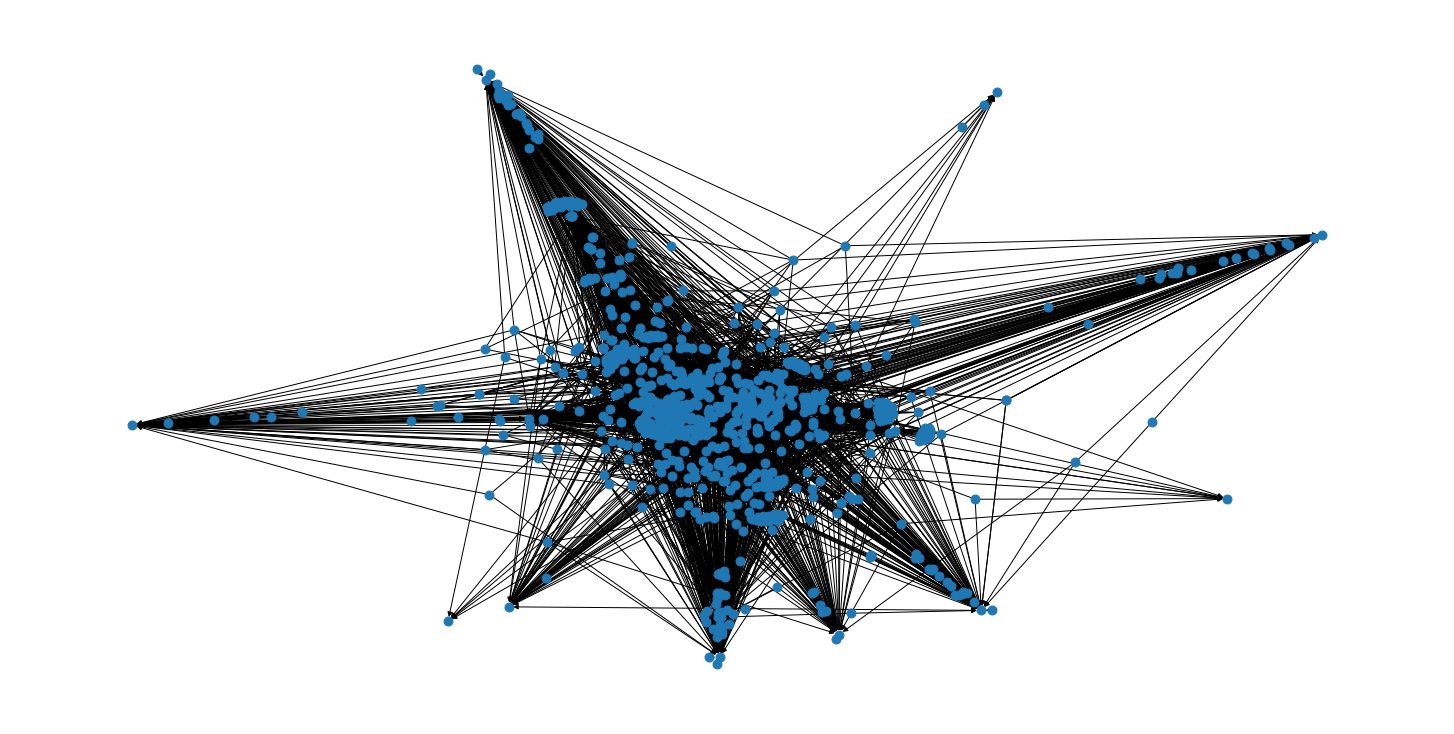

In [20]:
#just for illustrative purposes

plt.figure(figsize=(20, 10))

df1 = df[df['year'] == '2013']
G1 = nx.from_pandas_edgelist(df=df1[['source', 'target']], source='source', target='target', create_using=nx.DiGraph())

nx.draw(G1, node_size=80)

In [13]:
nx.info(G)

'DiGraph with 11256 nodes and 177291 edges'

In [14]:
round(nx.density(G), 5)

0.0014

In [15]:
round(nx.average_clustering(G), 3)

0.104

In [16]:
round(nx.average_shortest_path_length(G), 3)

0.926

(array([8.248e+03, 8.790e+02, 5.900e+02, 4.310e+02, 3.080e+02, 2.330e+02,
        1.330e+02, 9.500e+01, 7.400e+01, 6.300e+01, 4.500e+01, 3.400e+01,
        1.700e+01, 1.200e+01, 1.900e+01, 1.500e+01, 9.000e+00, 1.200e+01,
        9.000e+00, 6.000e+00]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.,
        275., 300., 325., 350., 375., 400., 425., 450., 475., 500.]),
 <a list of 20 Patch objects>)

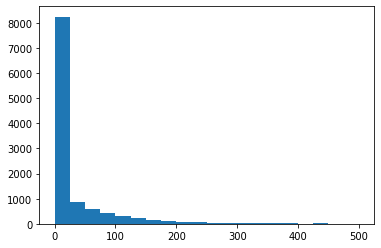

In [17]:
degrees = [G.degree(n) for n in G.nodes()]

plt.hist(degrees, range=(0, 500), bins=20)

In [18]:
nx.is_strongly_connected(G)

False

In [19]:
nx.number_strongly_connected_components(G)

8819